In [4]:
from collections import defaultdict
from itertools import product

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D

import wandb

rc_fonts = {
    "text.usetex": True,
    "text.latex.preamble": "\n".join(
        [r"\usepackage{libertine}", r"\usepackage[libertine]{newtxmath}", r"\usepackage{inconsolata}"]
    ),
}
mpl.rcParams.update(rc_fonts)


def format_ticks(x, pos):
    return str(int(x / 1000))


wandb.login()
api = wandb.Api()

In [2]:
tiny_lora = api.run("pico-lm/pico-relora/ixdq4sof")
small_lora = api.run("pico-lm/pico-relora/a8nvp3mi")
tiny_base = api.run("pico-lm/pico-relora/e8rwqdwk")
small_base = api.run("pico-lm/pico-relora/evrk6fbj")

In [3]:
data = {
    "lora": {
        "tiny": pd.DataFrame(tiny_lora.scan_history())
        .replace("NaN", np.nan, inplace=False)
        .infer_objects(copy=False),
        "small": pd.DataFrame(small_lora.scan_history())
        .replace("NaN", np.nan, inplace=False)
        .infer_objects(copy=False),
    },
    "base": {
        "tiny": pd.DataFrame(tiny_base.scan_history())
        .replace("NaN", np.nan, inplace=False)
        .infer_objects(copy=False),
        "small": pd.DataFrame(small_base.scan_history())
        .replace("NaN", np.nan, inplace=False)
        .infer_objects(copy=False),
    },
}

/var/folders/2y/6ry1xqnj2r9_fpqf_pp017mw0000gn/T/ipykernel_390/3679100403.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace("NaN", np.nan, inplace=False)
/var/folders/2y/6ry1xqnj2r9_fpqf_pp017mw0000gn/T/ipykernel_390/3679100403.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace("NaN", np.nan, inplace=False)


In [5]:
def get_across_ranges(
    df: pd.DataFrame, metric_name: str, step_mod: int = 1, step_mod_offset: int = 0, *ranges
):
    if not ranges:
        ranges = (range(12),)
    combos = product(*ranges)
    df = df.drop_duplicates(subset=["_step"], inplace=False)
    mask = df["_step"] % step_mod == step_mod_offset
    df = df[mask]
    x = [df[metric_name.format(*combo)].replace("NaN", np.nan).to_numpy() for combo in combos]
    return np.column_stack(x)

In [25]:
STEP_MOD = 2_000

In [26]:
per_data = {}
for mod in ("swiglu.w_2", "ov_circuit"):
    per_data[mod] = defaultdict(dict)
    for t in data:
        for s in data[t]:
            metr_str = (
                "per_val/_forward_module.module.layers.{}"
                + f".{mod}{'.base' if t == 'lora' else ''}.weights"
            )
            val = get_across_ranges(data[t][s], metr_str, step_mod=STEP_MOD)
            per_data[mod][t][s] = val

In [46]:
TICK_LABEL_SIZE = 14
AXIS_LABEL_SIZE = 16
SUP_LABEL_SIZE = 18

/var/folders/2y/6ry1xqnj2r9_fpqf_pp017mw0000gn/T/ipykernel_390/1012979695.py:93: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


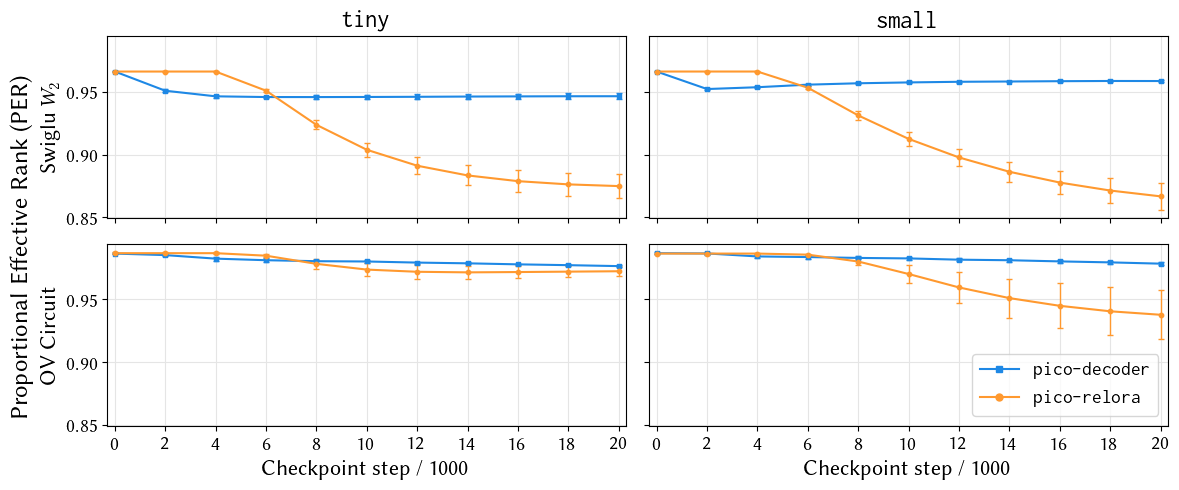

In [75]:
fig, axs = plt.subplots(2, 2, figsize=(12, 5), sharex=True, sharey=True)

axs = axs.flatten()

labels = [r"\texttt{pico-decoder}", r"\texttt{pico-relora}"]


colours = ["#1E88E5", "#FF992F"]
err_colours = ["#6EADE5", "#FFBA73"]
shapes = ["s", "o"]

legend_elements = []

data_key = [(mod, scale) for mod in ("swiglu.w_2", "ov_circuit") for scale in ("tiny", "small")]


for ax_id, ax in enumerate(axs):
    mod, scale = data_key[ax_id]
    base = per_data[mod]["base"][scale]
    lora = per_data[mod]["lora"][scale]

    xs = np.arange(0, 20_001, STEP_MOD)

    for idx, vs in enumerate((base, lora)):
        mu = np.mean(vs, axis=1, keepdims=True)
        sig = np.std(vs, axis=1, mean=mu, ddof=1)
        sem = sig / np.sqrt(vs.shape[1])

        ax.errorbar(
            xs,
            np.squeeze(mu),
            yerr=sem,
            color=colours[idx],
            ecolor=colours[idx],
            capsize=2,
            elinewidth=1,
            # fmt=,
            markersize=3,
            zorder=3,
        )

        ax.scatter(
            xs,
            np.squeeze(mu),
            color=colours[idx],
            s=10,
            marker=shapes[idx],
            zorder=5,
        )
        if ax_id < 1:
            legend_elements.append(
                Line2D(
                    [0],
                    [0],
                    color=colours[idx],
                    marker=shapes[idx],
                    linestyle="-",
                    label=r"\texttt{"
                    f"pico-{'decoder' if idx == 0 else 'relora'}",
                    markersize=5,
                )
            )

    ax.set_xticks(np.arange(0, 20_001, STEP_MOD), labels=[str(i) for i in range(0, 21, STEP_MOD // 1_000)])
    ax.set_xlim(-300, 20_300)
    ax.set_axisbelow(True)
    ax.grid(which="major", axis="both", color="#E5E5E5")

    ax.tick_params("both", labelsize=TICK_LABEL_SIZE)

    if ax_id == 0:
        ax.set_ylabel(r"Swiglu $W_2$", fontdict={"size": AXIS_LABEL_SIZE})
        ax.text(0.5, 1.05, r"\texttt{tiny}", ha="center", fontsize=SUP_LABEL_SIZE, transform=ax.transAxes)
    elif ax_id == 1:
        ax.text(0.5, 1.05, r"\texttt{small}", ha="center", fontsize=SUP_LABEL_SIZE, transform=ax.transAxes)
    elif ax_id == 2:
        ax.set_ylabel("OV Circuit", fontdict={"size": AXIS_LABEL_SIZE})
    elif ax_id == 3:
        ax.legend(
            handles=legend_elements,
            fontsize=TICK_LABEL_SIZE,
            loc="lower right",
            bbox_to_anchor=(1, 0),
        )

    if ax_id > 1:
        ax.set_xlabel(r"Checkpoint step / 1000", fontsize=AXIS_LABEL_SIZE)

fig.supylabel("Proportional Effective Rank (PER)", size=SUP_LABEL_SIZE)

# fig.supxlabel(r"Checkpoint step / 1000", fontsize=AXIS_LABEL_SIZE, x=0.53)
fig.tight_layout()
fig.show()
fig.savefig("../graphs/per.pdf")

# OV circuit fst vs last

/var/folders/2y/6ry1xqnj2r9_fpqf_pp017mw0000gn/T/ipykernel_390/2322788372.py:98: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


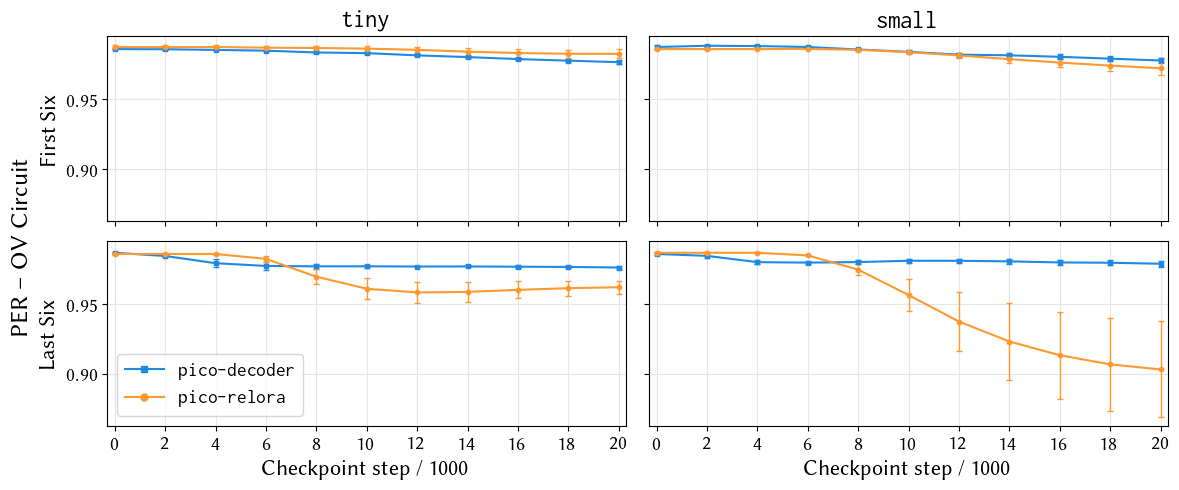

In [76]:
fig, axs = plt.subplots(2, 2, figsize=(12, 5), sharex=True, sharey=True)

axs = axs.flatten()

labels = [r"\texttt{pico-decoder}", r"\texttt{pico-relora}"]


colours = ["#1E88E5", "#FF992F"]
err_colours = ["#6EADE5", "#FFBA73"]
shapes = ["s", "o"]

legend_elements = []

mod = "ov_circuit"

data_key = [(mod, scale) for scale in ("tiny", "small")]


for ax_id, ax in enumerate(axs):
    mod, scale = data_key[ax_id % 2]
    base = per_data[mod]["base"][scale]
    lora = per_data[mod]["lora"][scale]

    xs = np.arange(0, 20_001, STEP_MOD)

    for idx, vs in enumerate((base, lora)):
        if ax_id < 2:
            vs = vs[:, :6]
        else:
            vs = vs[:, 6:]
        mu = np.mean(vs, axis=1, keepdims=True)
        sig = np.std(vs, axis=1, mean=mu, ddof=1)
        sem = sig / np.sqrt(vs.shape[1])

        ax.errorbar(
            xs,
            np.squeeze(mu),
            yerr=sem,
            color=colours[idx],
            ecolor=colours[idx],
            capsize=2,
            elinewidth=1,
            # fmt=,
            markersize=3,
            zorder=3,
        )

        ax.scatter(
            xs,
            np.squeeze(mu),
            color=colours[idx],
            s=10,
            marker=shapes[idx],
            zorder=5,
        )
        if ax_id < 1:
            legend_elements.append(
                Line2D(
                    [0],
                    [0],
                    color=colours[idx],
                    marker=shapes[idx],
                    linestyle="-",
                    label=r"\texttt{"
                    f"pico-{'decoder' if idx == 0 else 'relora'}",
                    markersize=5,
                )
            )

    ax.set_xticks(np.arange(0, 20_001, STEP_MOD), labels=[str(i) for i in range(0, 21, STEP_MOD // 1_000)])
    ax.set_xlim(-300, 20_300)
    ax.set_axisbelow(True)
    ax.grid(which="major", axis="both", color="#E5E5E5")

    ax.tick_params("both", labelsize=TICK_LABEL_SIZE)

    if ax_id == 0:
        ax.set_ylabel(r"First Six", fontdict={"size": AXIS_LABEL_SIZE})
        ax.text(0.5, 1.05, r"\texttt{tiny}", ha="center", fontsize=SUP_LABEL_SIZE, transform=ax.transAxes)
    elif ax_id == 1:
        ax.text(0.5, 1.05, r"\texttt{small}", ha="center", fontsize=SUP_LABEL_SIZE, transform=ax.transAxes)
    elif ax_id == 2:
        ax.set_ylabel("Last Six", fontdict={"size": AXIS_LABEL_SIZE})
        ax.legend(
            handles=legend_elements,
            fontsize=TICK_LABEL_SIZE,
            loc="lower left",
            bbox_to_anchor=(0, 0),
        )

    if ax_id > 1:
        ax.set_xlabel(r"Checkpoint step / 1000", fontsize=AXIS_LABEL_SIZE)

fig.supylabel("PER -- OV Circuit", size=SUP_LABEL_SIZE)

# fig.supxlabel(r"Checkpoint step / 1000", fontsize=AXIS_LABEL_SIZE, x=0.53)
fig.tight_layout()
fig.show()
fig.savefig("../graphs/per-fst-lst.pdf")